# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy 
import seaborn as sns
import os

# EDA

In [3]:
train = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
train.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

## Explaining the data

* Each row of the train.csv represents a window of 50 seconds of the signal in its corresponding parquet file.
* The time of the first sample in the window is represented in the “eeg_label_offset_seconds” column with its corresponding id in the “eeg_sub_id” column (see the figure below)
* Windows can be overlapped with each other depending on the offset given.
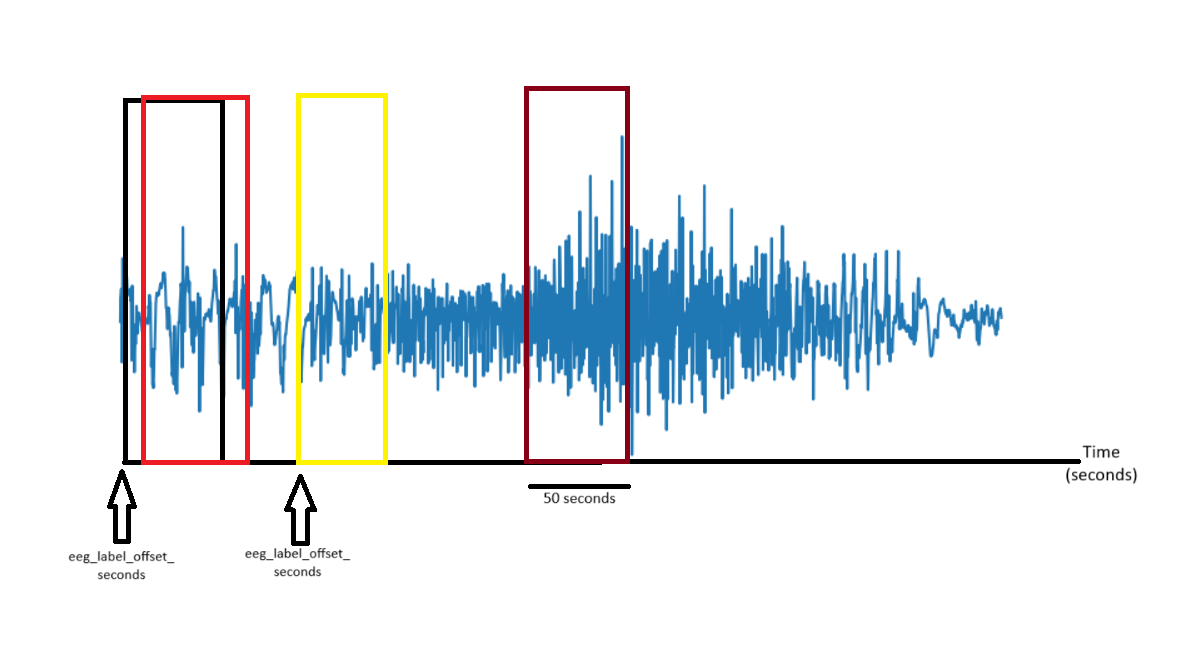

* Spectrograms represent 10 min window of the signal
* The middle time of the window is the same in eeg and spectrogram.
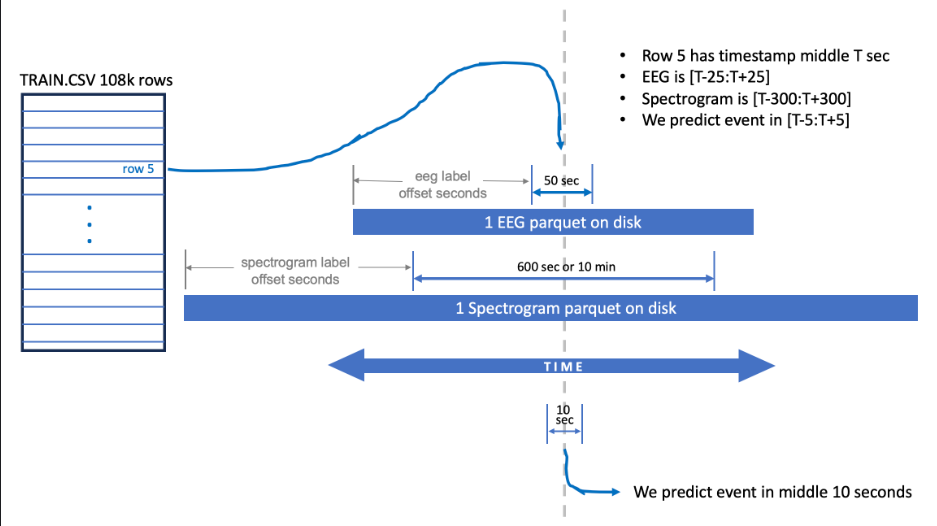


## Each patient has multiple eeg_id => Each patient has multiple parquet file 

In [25]:
print(f"Number of patients:{train['patient_id'].nunique()}")

Number of patients:1950


In [26]:
print(f"Number of unique EEGs:{train['eeg_id'].nunique()}")

Number of unique EEGs:17089


## What are the missing values

In [28]:
L = os.listdir("/kaggle/input/hms-harmful-brain-activity-classification/train_eegs")
print(f"There are {len(list(L))} file in the train_eegs folder which does not match the number of the unique eeg_id(17089) in train.csv")

There are 17300 file in the train_eegs folder which does not match the number of the unique eeg_id(17089) in train.csv


In [29]:
missing_eeg_ids = [int(num[:-8]) for num in L if int(num[:-8]) not in train['eeg_id'].unique()]
print(f"There are {len(missing_eeg_ids)} missing value")

There are 211 missing value


No missing values in spectrograms

In [33]:
F = os.listdir("/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms")
print(f'There are {len(F)} spectrograms parquet file')

There are 11138 spectrograms parquet file


In [31]:
print(f"Number of unique spectograms:{train['spectrogram_id'].nunique()}")

Number of unique spectograms:11138


## Some parquet files only have 1 windowed label.

In [23]:
id_counts = train.groupby('eeg_id').size()
single_row_ids = id_counts[id_counts == 1]
num_single_row_ids = len(single_row_ids)
print("Number of IDs with only one row:", num_single_row_ids)

Number of IDs with only one row: 6324


## Length of Signals

In [6]:
EEG_IDS = train.eeg_id.unique()
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
len_of_eeg_signals = {}
for i, eeg_id in enumerate(EEG_IDS):    
    Signals = pd.read_parquet(f'{PATH}{eeg_id}.parquet')
    len_of_eeg_signals[eeg_id] = len(Signals)

In [ ]:
values = list(len_of_eeg_signals.values())

Each sample is 0.005 seconds since the sampling frequency is 200 Hz => The total time of the signal = no_of_samples * 0.005

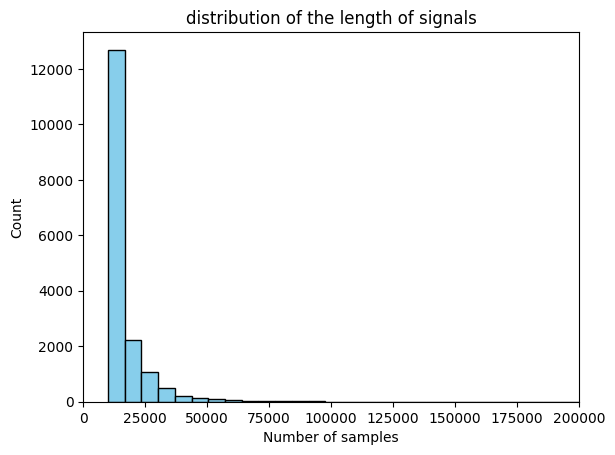

In [36]:
plt.hist(values, bins=100, color='skyblue', edgecolor='black')
plt.xlim(0, 200000)
plt.xlabel('Number of samples')
plt.ylabel('Count')
plt.title('distribution of the length of signals')
plt.show()

## Categorical Values

In [37]:
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
categorical_summary = train[categorical_columns].describe()
categorical_summary

,expert_consensus
count,106800
unique,6
top,Seizure
freq,20933


In [38]:
categorical_columns

Index(['expert_consensus'], dtype='object')

In [39]:
list(train['expert_consensus'].unique())

['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD']

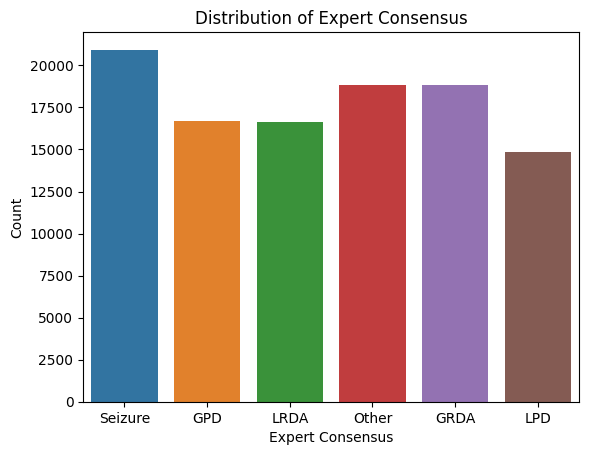

In [40]:
sns.countplot(data=train, x='expert_consensus')
plt.title('Distribution of Expert Consensus')
plt.xlabel('Expert Consensus')
plt.ylabel('Count')
plt.show()

We need to note here that the above distribution is on the overlapped windows, not unique EEG_ids 

## Distribution of Votes

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

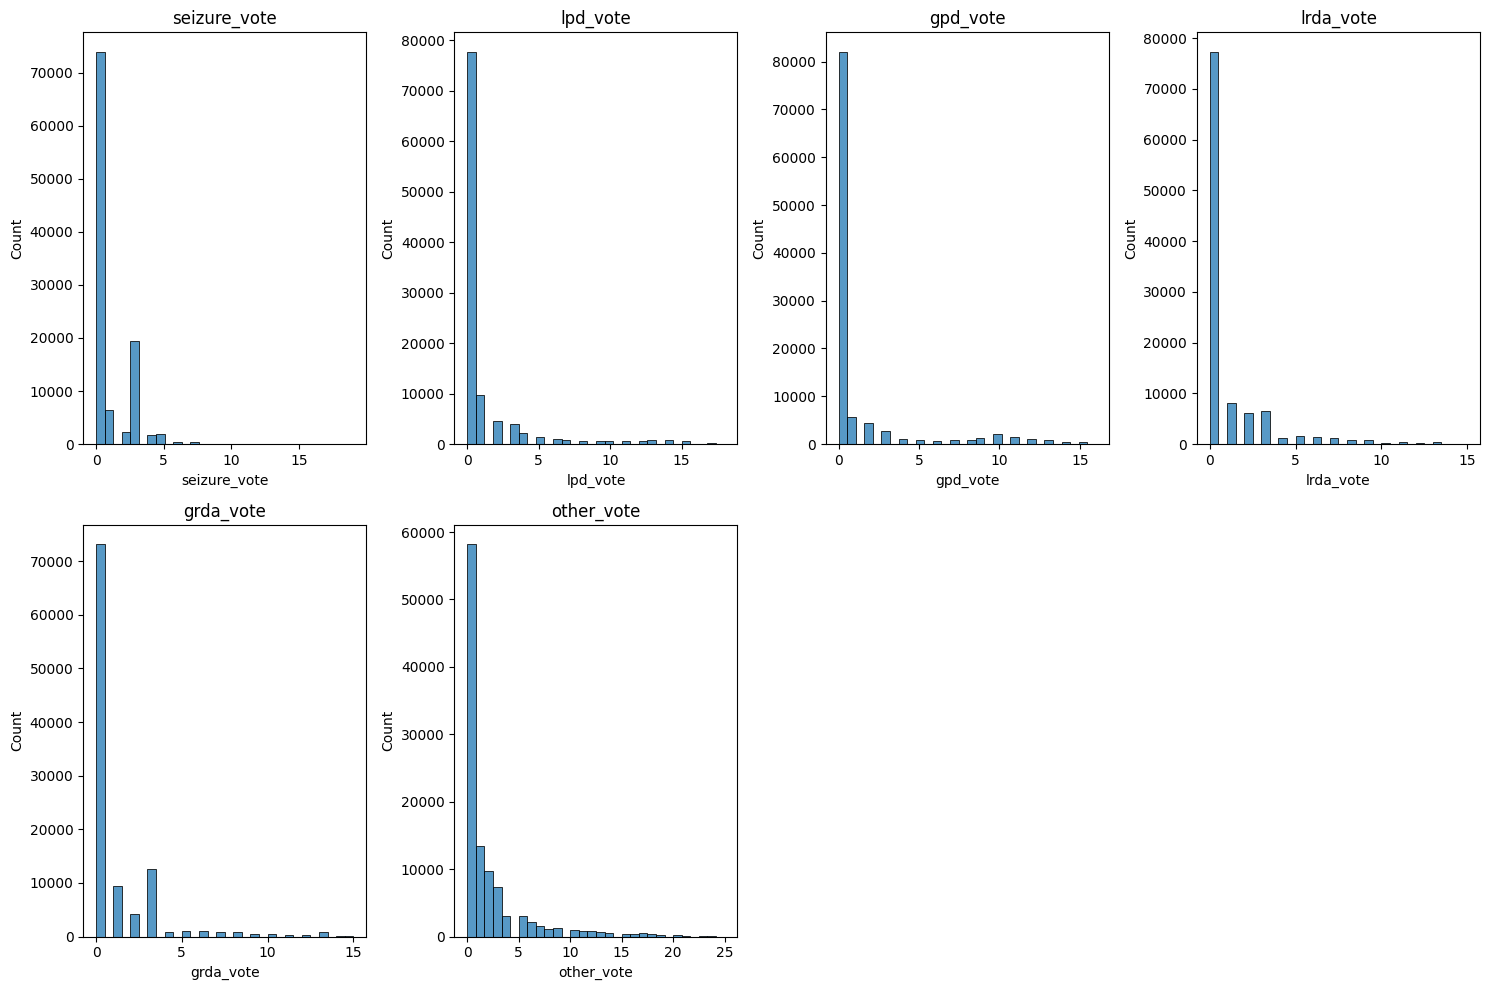

In [48]:
targets = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
plt.figure(figsize=(15, 10))
for i, column in enumerate(targets, 1):
    plt.subplot(2, 4, i)
    sns.histplot(train[column], kde=False, bins=30)
    plt.title(column)
plt.tight_layout()

Correlation between Votes

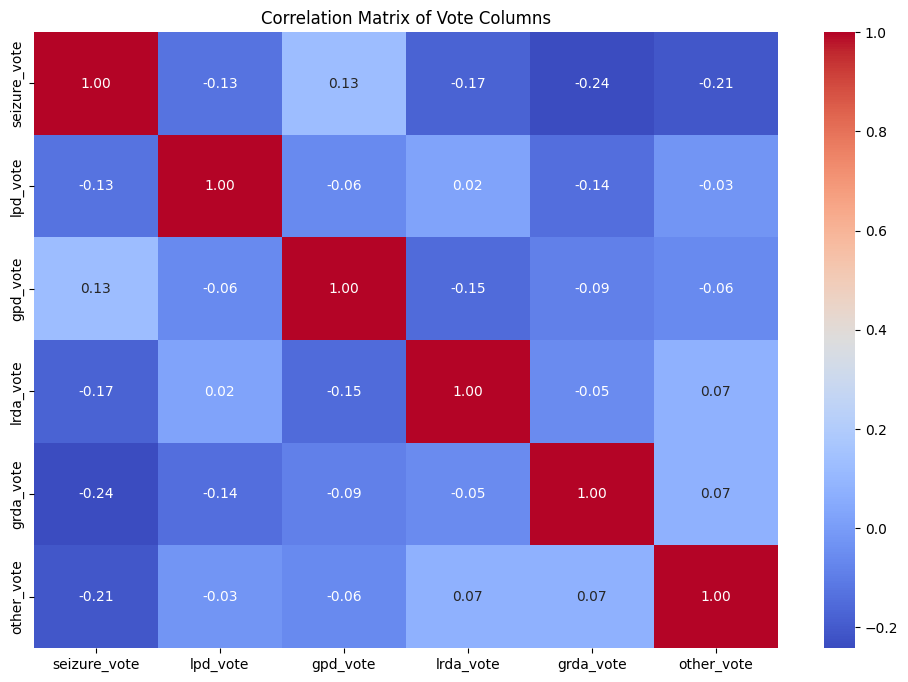

In [42]:
correlation_targets = train[targets].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_targets, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Vote Columns')
plt.show()

There is some negative correlation between grda_votes and seizure_votes and between seizure_votes and other_votes.

## Which sample are Idealized, Proto and Edge cases

* Idealizedd: High level of agreement (>90% of specific vote)
* Proto: ~1/2 give a label as "other" and ~1/2 give anthor label of the remaining votes
* Edge: vote are ~splited  between 2 of the 5 named patterns

In [44]:

Idealized = []
Proto = []
Edge = []
for i in range(len(train)):
    votes = list(train.iloc[i][-6:])
    sum_1 = sum(votes)
    #votes_prob = [i/sum_1 for i in votes]
    max_index = max(range(len(votes)), key = lambda i: votes[i])
    last_prob = votes[-1]/sum_1
    if votes[max_index]/sum_1 > 0.9:
                Idealized.append(train.iloc[i]['eeg_id'])
    elif last_prob >= 0.45:
            second_largest_prob = sorted(votes)[-2]
            if last_prob >= 0.45 and second_largest_prob >= 0.45:
                    Proto.append(train.iloc[i]['eeg_id'])
            else:
                    Edge.append(train.iloc[i]['eeg_id'])
    else:
                Edge.append(train.iloc[i]['eeg_id']) 
    

In [46]:
print(f"The dataset is formed of:\n{len(Idealized)} Idealized window\n{len(Proto)} Proto window\n{len(Edge)} Edge window")

The dataset is formed of:
54977 Idealized window
11487 Proto window
40336 Edge window
